# Student Performance Predictions Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Functions

In [5]:
def check_nulls_dupes(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of Dupes {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels= unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.ylabel("Frequency")
  plt.show()


# EDA Analysis

In [13]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/student_performance.csv")
df

,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,1,John,Male,85,15,78,1,High,80
1,2,Sarah,Female,90,20,85,2,Medium,87
2,3,Alex,Male,78,10,65,0,Low,68
3,4,Michael,Male,92,25,90,3,High,92
4,5,Emma,Female,88,18,82,2,Medium,85
5,6,Olivia,Female,95,30,88,1,High,90
6,7,Daniel,Male,70,8,60,0,Low,62
7,8,Sophia,Female,85,17,77,1,Medium,78
8,9,James,Male,82,12,70,2,Low,72
9,10,Isabella,Female,91,22,86,3,High,88


In [14]:
df.drop(["StudentID", 'Name'], axis=1, inplace=True)

In [15]:
new_df = df.copy()

mapping = {"High":2,"Medium":1, "Low":0}
new_df["Gender"] = df["Gender"].apply(lambda x: 0 if x == "Male" else 1)
new_df["ParentalSupport"] = new_df["ParentalSupport"].map(mapping)

In [16]:
new_df

,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,0,85,15,78,1,2,80
1,1,90,20,85,2,1,87
2,0,78,10,65,0,0,68
3,0,92,25,90,3,2,92
4,1,88,18,82,2,1,85
5,1,95,30,88,1,2,90
6,0,70,8,60,0,0,62
7,1,85,17,77,1,1,78
8,0,82,12,70,2,0,72
9,1,91,22,86,3,2,88


# HeatMap

<Axes: >

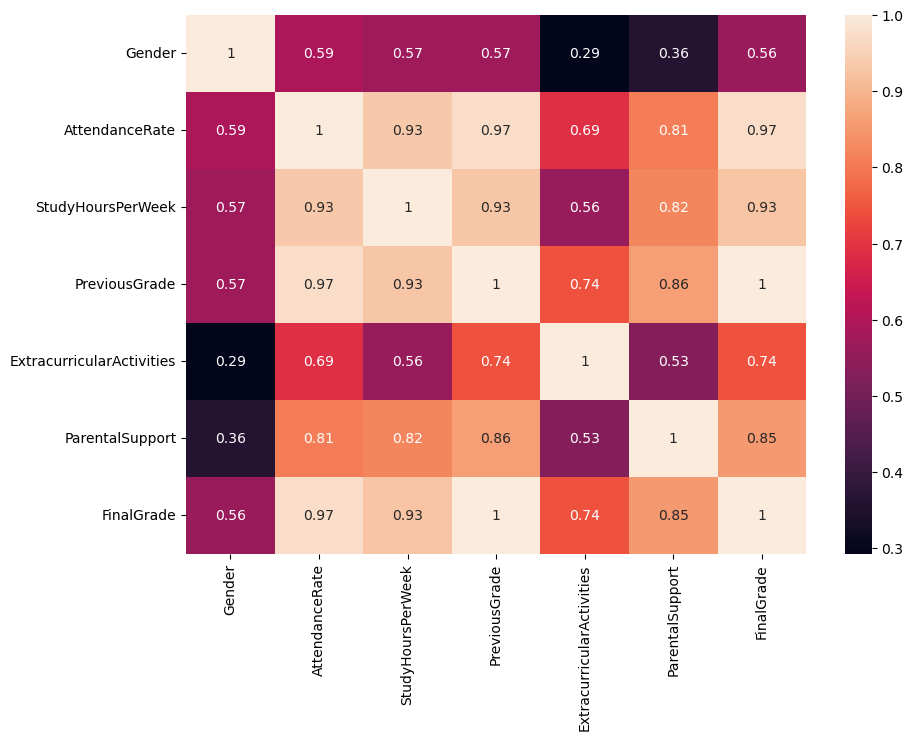

In [18]:
relations = new_df.corr()

plt.figure(figsize=(10,7))
sns.heatmap(data=relations, annot=True)